In [128]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.metrics import mean_squared_error
from math import sqrt

In [129]:
train = pd.read_csv("../data/schemas/warm_up/TrainSet.csv", sep=",")
validation = pd.read_csv("../data/schemas/warm_up/ValidationSet.csv", sep=",")
test = pd.read_csv("../data/schemas/warm_up/TestSet.csv", sep=",")

In [130]:
# Global variables

NUM_OF_TIMESTEPS_INPUT = 48
NUM_OF_TIMESTEPS_OUTPUT = 24

THRESHOLD = 0.4   # For feature selection

In [131]:
columns_to_predict = ["kg_CO2/kWh", "Avg solar generation"]

independent_variables = []

for column in train:
    if abs(train[column].corr(train[columns_to_predict[0]])) > THRESHOLD: #or abs(train[column].corr(train[columns_to_predict[1]])) > THRESHOLD:
        independent_variables.append(column)

#[independent_variables.remove(i) for i in columns_to_predict]
independent_variables.remove(columns_to_predict[0])
    
if "Index" in independent_variables:
    independent_variables.remove("Index")
if "Solar Generation (W/kW)_1" in independent_variables:
    independent_variables.remove("Solar Generation (W/kW)_1")
if "Solar Generation (W/kW)_2" in independent_variables:
    independent_variables.remove("Solar Generation (W/kW)_2")
if "Solar Generation (W/kW)_3" in independent_variables:
    independent_variables.remove("Solar Generation (W/kW)_3")
    
print(independent_variables)

['Hour_1', 'Hour_2', 'Hour_3', 'Occupant Count (people)_3', '12h Outdoor Drybulb Temperature (C)', '24h Outdoor Drybulb Temperature (C)', '12h Outdoor Relative Humidity (%)', '6h Direct Solar Radiation (W/m2)', '12h Direct Solar Radiation (W/m2)']


Prepare the data

In [132]:
# Split the X and Y for all sets

# Train set
X_train_default = train[independent_variables]
Y_train_default = train[columns_to_predict]

# Validation set, also include the data from train that was used only as output to get more datapoints
X_val_default = pd.concat([X_train_default.tail(NUM_OF_TIMESTEPS_OUTPUT), validation[independent_variables]], ignore_index=True)
Y_val_default = pd.concat([Y_train_default.tail(NUM_OF_TIMESTEPS_OUTPUT), validation[columns_to_predict]], ignore_index=True)

# Test set, also include the data from train that was used only as output to get more datapoints
X_test_default = pd.concat([X_val_default.tail(NUM_OF_TIMESTEPS_OUTPUT), test[independent_variables]], ignore_index=True)
Y_test_default = pd.concat([Y_val_default.tail(NUM_OF_TIMESTEPS_OUTPUT), test[columns_to_predict]], ignore_index=True)

NUM_OF_ROWS_TRAIN, NUM_OF_FEATURES = X_train_default.shape

print(X_train_default.shape)
print(X_val_default.shape)
print(X_test_default.shape)

(576, 9)
(96, 9)
(96, 9)


In [133]:
# Function to prepare the data into batches that will be passed into the model

def create_sequences(input_data, output_data, timesteps_input, timesteps_output):
    sequences, targets = [], []
    for i in range(len(input_data) - timesteps_input - timesteps_output + 1):
        seq = input_data[i:i + timesteps_input]
        target = output_data[i + timesteps_input: i + timesteps_input + timesteps_output]
        sequences.append(seq)
        targets.append(target)

    return np.array(sequences), np.array(targets)

In [134]:
X_train, Y_train = create_sequences(X_train_default, Y_train_default, NUM_OF_TIMESTEPS_INPUT, NUM_OF_TIMESTEPS_OUTPUT)
X_val, Y_val = create_sequences(X_val_default, Y_val_default, NUM_OF_TIMESTEPS_INPUT, NUM_OF_TIMESTEPS_OUTPUT)
X_test, Y_test = create_sequences(X_test_default, Y_test_default, NUM_OF_TIMESTEPS_INPUT, NUM_OF_TIMESTEPS_OUTPUT)

print(f"X_train = {X_train.shape}, Y_train = {Y_train.shape}\n"
      f"X_val = {X_val.shape}, Y_val = {Y_val.shape}\n"
      f"X_test = {X_test.shape}, Y_test = {Y_test.shape}")

X_train = (505, 48, 9), Y_train = (505, 24, 2)
X_val = (25, 48, 9), Y_val = (25, 24, 2)
X_test = (25, 48, 9), Y_test = (25, 24, 2)


In [135]:
print(Y_train[:, :, 0])

[[0.59739428 0.49429981 0.38708765 ... 0.73547528 0.69513525 0.71729728]
 [0.49429981 0.38708765 0.28880037 ... 0.69513525 0.71729728 0.6633147 ]
 [0.38708765 0.28880037 0.2346659  ... 0.71729728 0.6633147  0.55539687]
 ...
 [0.47416969 0.39741721 0.28594384 ... 0.4397153  0.45619247 0.45482902]
 [0.39741721 0.28594384 0.16805223 ... 0.45619247 0.45482902 0.41836388]
 [0.28594384 0.16805223 0.12974031 ... 0.45482902 0.41836388 0.39162712]]


In [136]:
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras import layers, models

tscv = TimeSeriesSplit(n_splits = 4) # For cross-validation

callback = keras.callbacks.EarlyStopping(monitor='loss', patience = 8) #patience parameter to be adjusted

loss = []
val_loss = []
loss_1 = []
val_loss_1 = []
loss_2 = []
val_loss_2 = []


for train_data, test_data in tscv.split(X_train):
    X_train_current_split, X_test_current_split = X_train[train_data], X_train[test_data]
    y_train_current_split, y_test_current_split = Y_train[train_data], Y_train[test_data]
    
    # Input layer
    input_layer = layers.Input(shape=(NUM_OF_TIMESTEPS_INPUT, NUM_OF_FEATURES))
    
    # Permute layer
    permute_layer = layers.Permute((2, 1))(input_layer)
    
    # Flatten layer
    flatten_layer = layers.Flatten()(permute_layer)
    
    # Dense layers for variable 1
    dense1 = layers.Dense(1200, activation='tanh')(flatten_layer)
    dense2 = layers.Dense(600, activation='tanh')(dense1)
    dense3 = layers.Dense(240, activation='tanh')(dense2)
    output_variable1 = layers.Dense(24, name='output_variable1')(dense3)
    
    # Dense layers for variable 2
    dense4 = layers.Dense(1200, activation='tanh')(flatten_layer)
    dense5 = layers.Dense(600, activation='tanh')(dense4)
    dense6 = layers.Dense(240, activation='tanh')(dense5)
    output_variable2 = layers.Dense(24, name='output_variable2')(dense6)
    
    # Define the model
    model = models.Model(inputs=input_layer, outputs=[output_variable1, output_variable2])

    model.compile(
        optimizer='adam',
        loss={'output_variable1': 'mean_squared_error', 'output_variable2': 'mean_squared_error'}
    ) #types of optimizer, loss function to be adjusted
    
    history = model.fit(X_train_current_split, y={"output_variable1": y_train_current_split[:, :, 0], 
                                                  "output_variable2": y_train_current_split[:, :, 1]},
              epochs=100, 
              validation_data=(
                  X_test_current_split,
                {
                    "output_variable1": y_test_current_split[:, :, 0],
                    "output_variable2": y_test_current_split[:, :, 1],
                },
              ),
              # validation_split = 0.8,
              verbose=1,
              callbacks=callback
    )
    loss.append(model.history.history['loss'])
    val_loss.append(model.history.history['val_loss'])
    
    loss_1.append(model.history.history['output_variable1_loss'])
    val_loss_1.append(model.history.history['val_output_variable1_loss'])
    
    loss_2.append(model.history.history['output_variable2_loss'])
    val_loss_2.append(model.history.history['val_output_variable2_loss'])

Epoch 1/100
4/4 [==============================] - 2s 87ms/step - loss: 3.1317 - output_variable1_loss: 1.3789 - output_variable2_loss: 1.7528 - val_loss: 0.5283 - val_output_variable1_loss: 0.2915 - val_output_variable2_loss: 0.2368
Epoch 2/100
4/4 [==============================] - 0s 35ms/step - loss: 0.4572 - output_variable1_loss: 0.2225 - output_variable2_loss: 0.2346 - val_loss: 0.2448 - val_output_variable1_loss: 0.1402 - val_output_variable2_loss: 0.1045
Epoch 3/100
4/4 [==============================] - 0s 38ms/step - loss: 0.1831 - output_variable1_loss: 0.1050 - output_variable2_loss: 0.0781 - val_loss: 0.1571 - val_output_variable1_loss: 0.0860 - val_output_variable2_loss: 0.0711
Epoch 4/100
4/4 [==============================] - 0s 39ms/step - loss: 0.1166 - output_variable1_loss: 0.0524 - output_variable2_loss: 0.0642 - val_loss: 0.1177 - val_output_variable1_loss: 0.0737 - val_output_variable2_loss: 0.0440
Epoch 5/100
4/4 [==============================] - 0s 38ms/step 

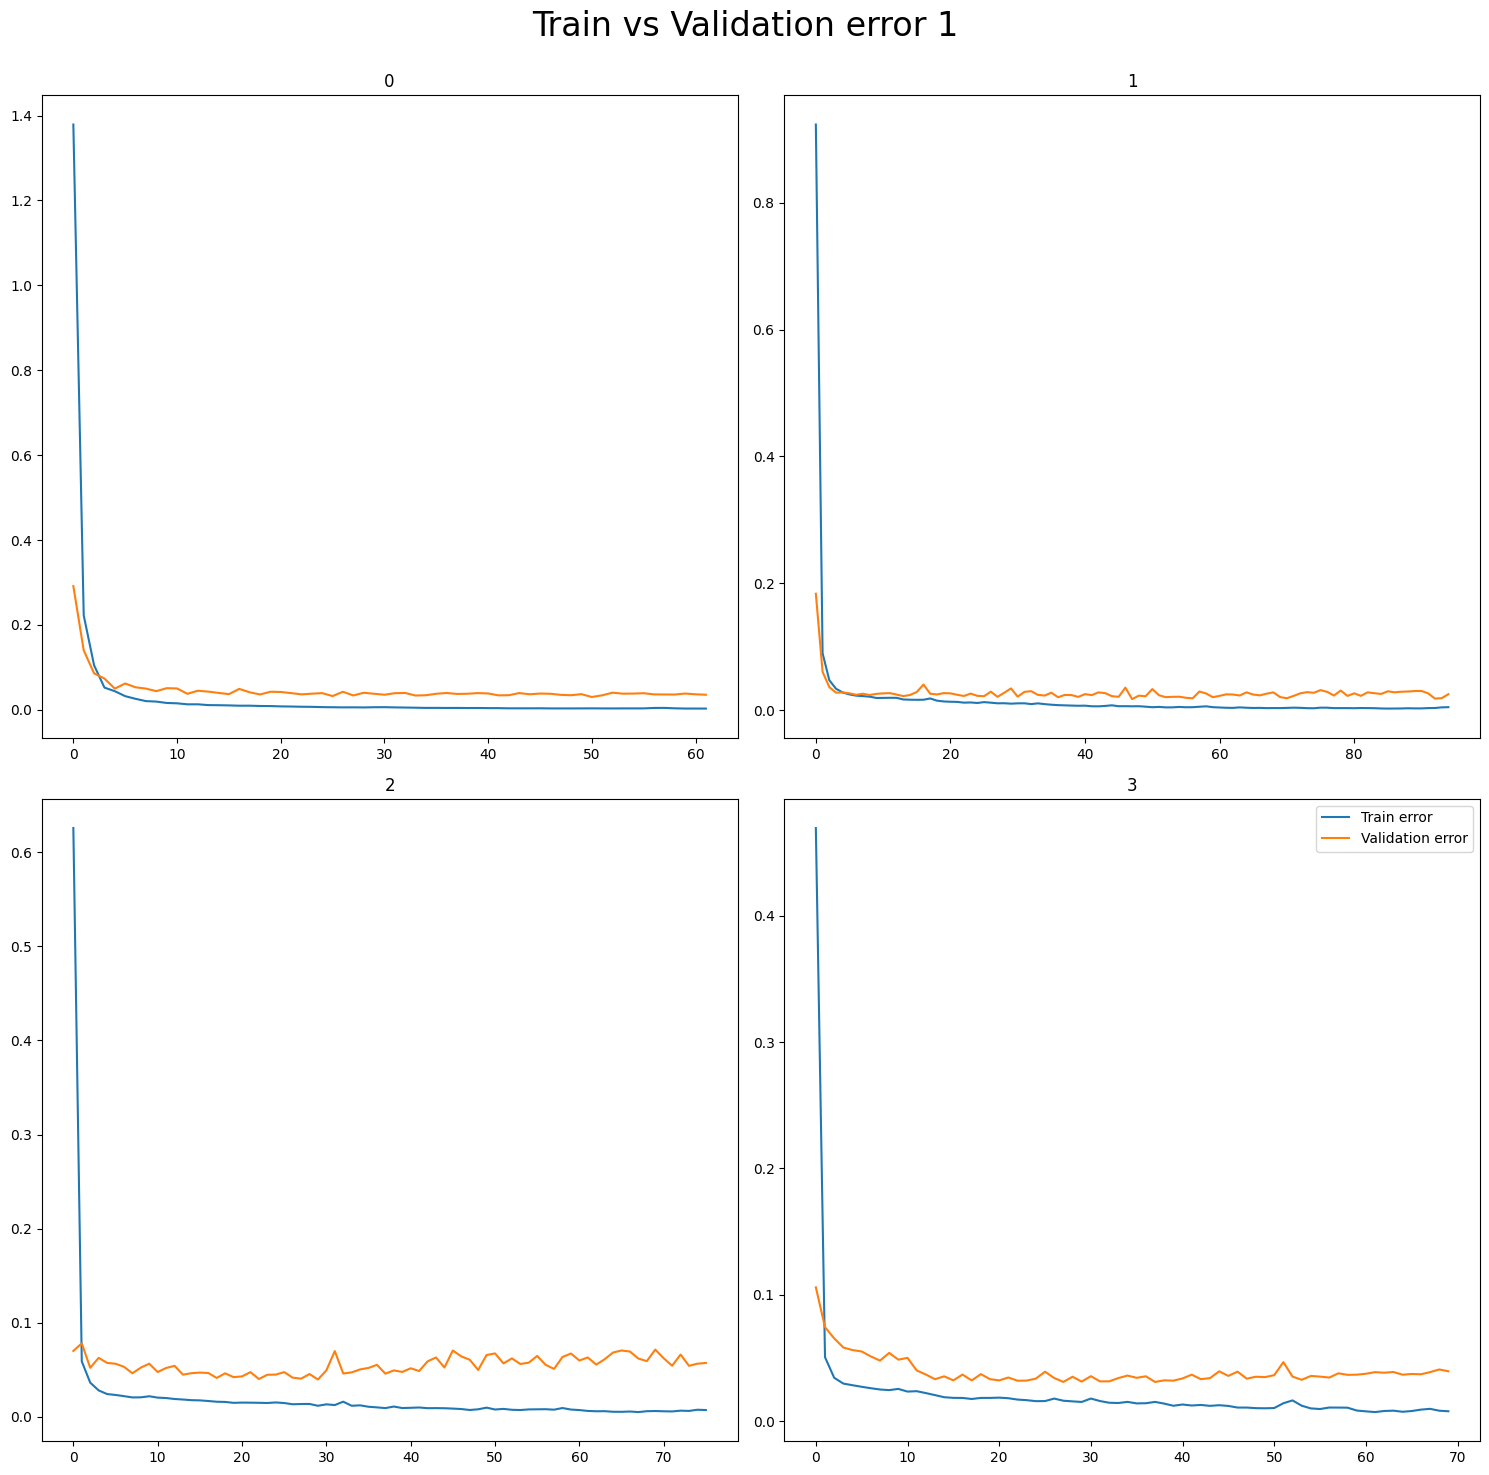

In [137]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
axs = axs.flatten()

for i, column in enumerate(loss_1):
    ax = axs[i]
    ax.plot(column, label="Train error")
    ax.plot(val_loss_1[i], label="Validation error")
    ax.title.set_text(i)
    
fig.suptitle("Train vs Validation error 1", fontsize=24)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.legend()
plt.show()

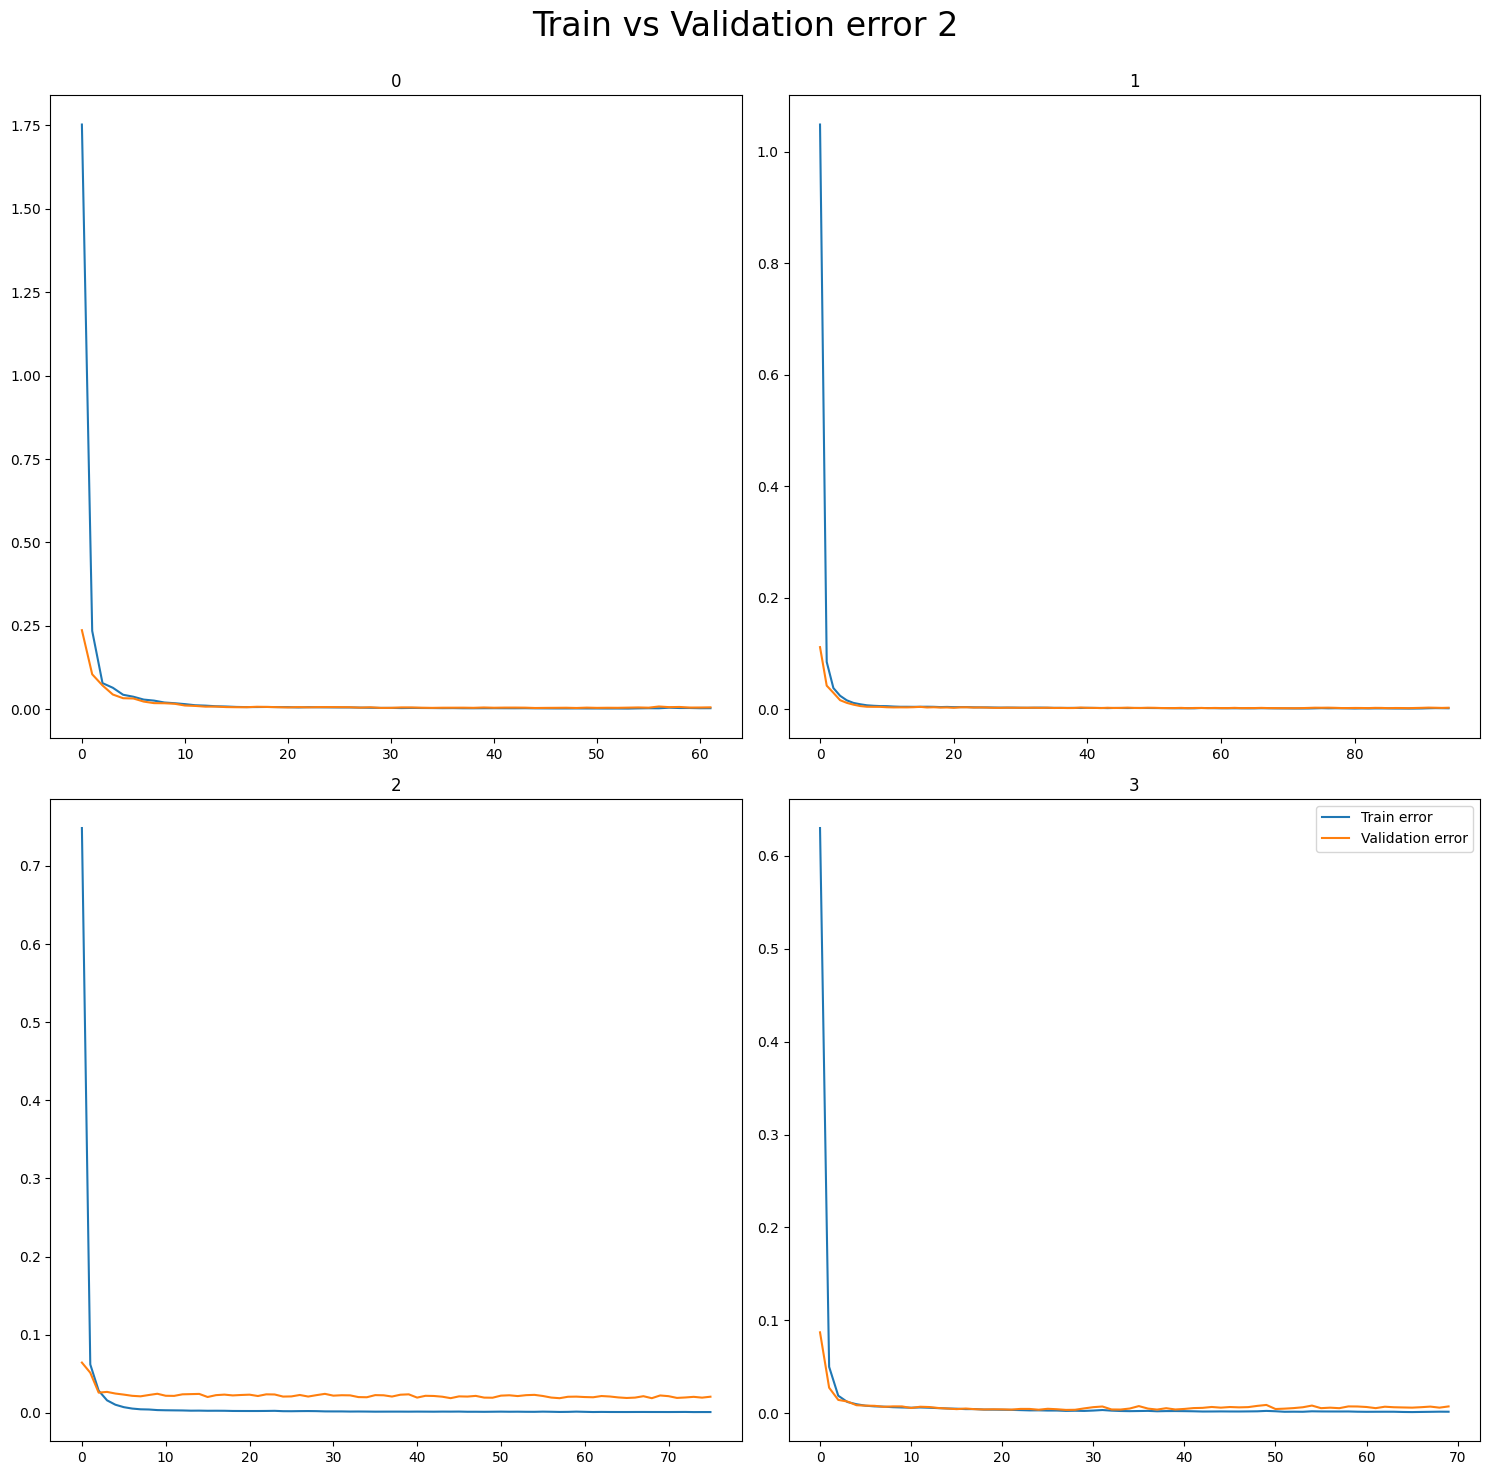

In [138]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
axs = axs.flatten()

for i, column in enumerate(loss_2):
    ax = axs[i]
    ax.plot(column, label="Train error")
    ax.plot(val_loss_2[i], label="Validation error")
    ax.title.set_text(i)
    
fig.suptitle("Train vs Validation error 2", fontsize=24)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.legend()
plt.show()

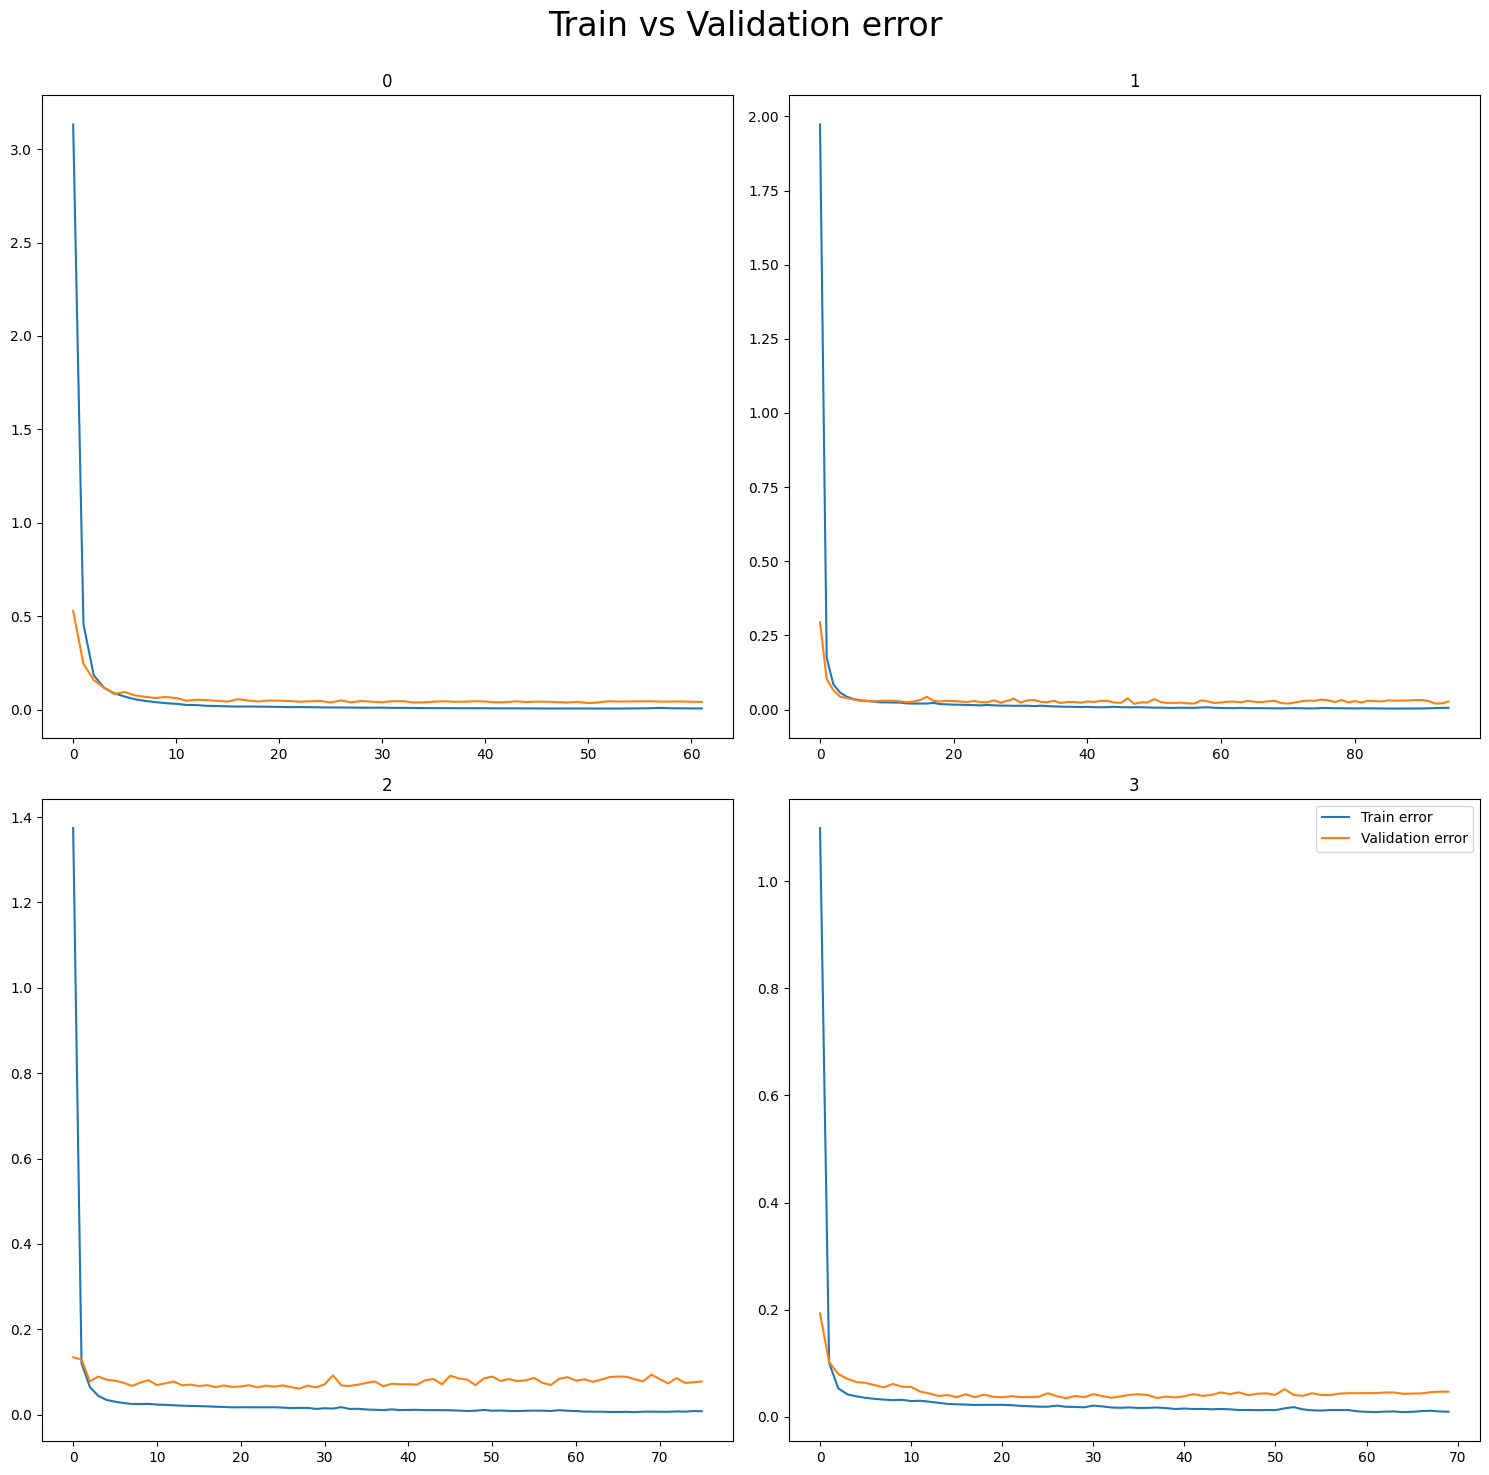

In [139]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
axs = axs.flatten()

for i, column in enumerate(loss):
    ax = axs[i]
    ax.plot(column, label="Train error")
    ax.plot(val_loss[i], label="Validation error")
    ax.title.set_text(i)
    
fig.suptitle("Train vs Validation error", fontsize=24)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.legend()
plt.show()

In [140]:
# Evaluate the model on the test data
predictions_1 = []
predictions_2 = []
#print(len(eval_target_variables))

for i in range(len(Y_val)):
    current_batch = X_val[i].reshape((1, NUM_OF_TIMESTEPS_INPUT, NUM_OF_FEATURES))
    curr_pred1, curr_pred2 = model.predict(current_batch)
    predictions_1.append(curr_pred1)
    predictions_2.append(curr_pred2)

1/1 [==============================] - 0s 20ms/step


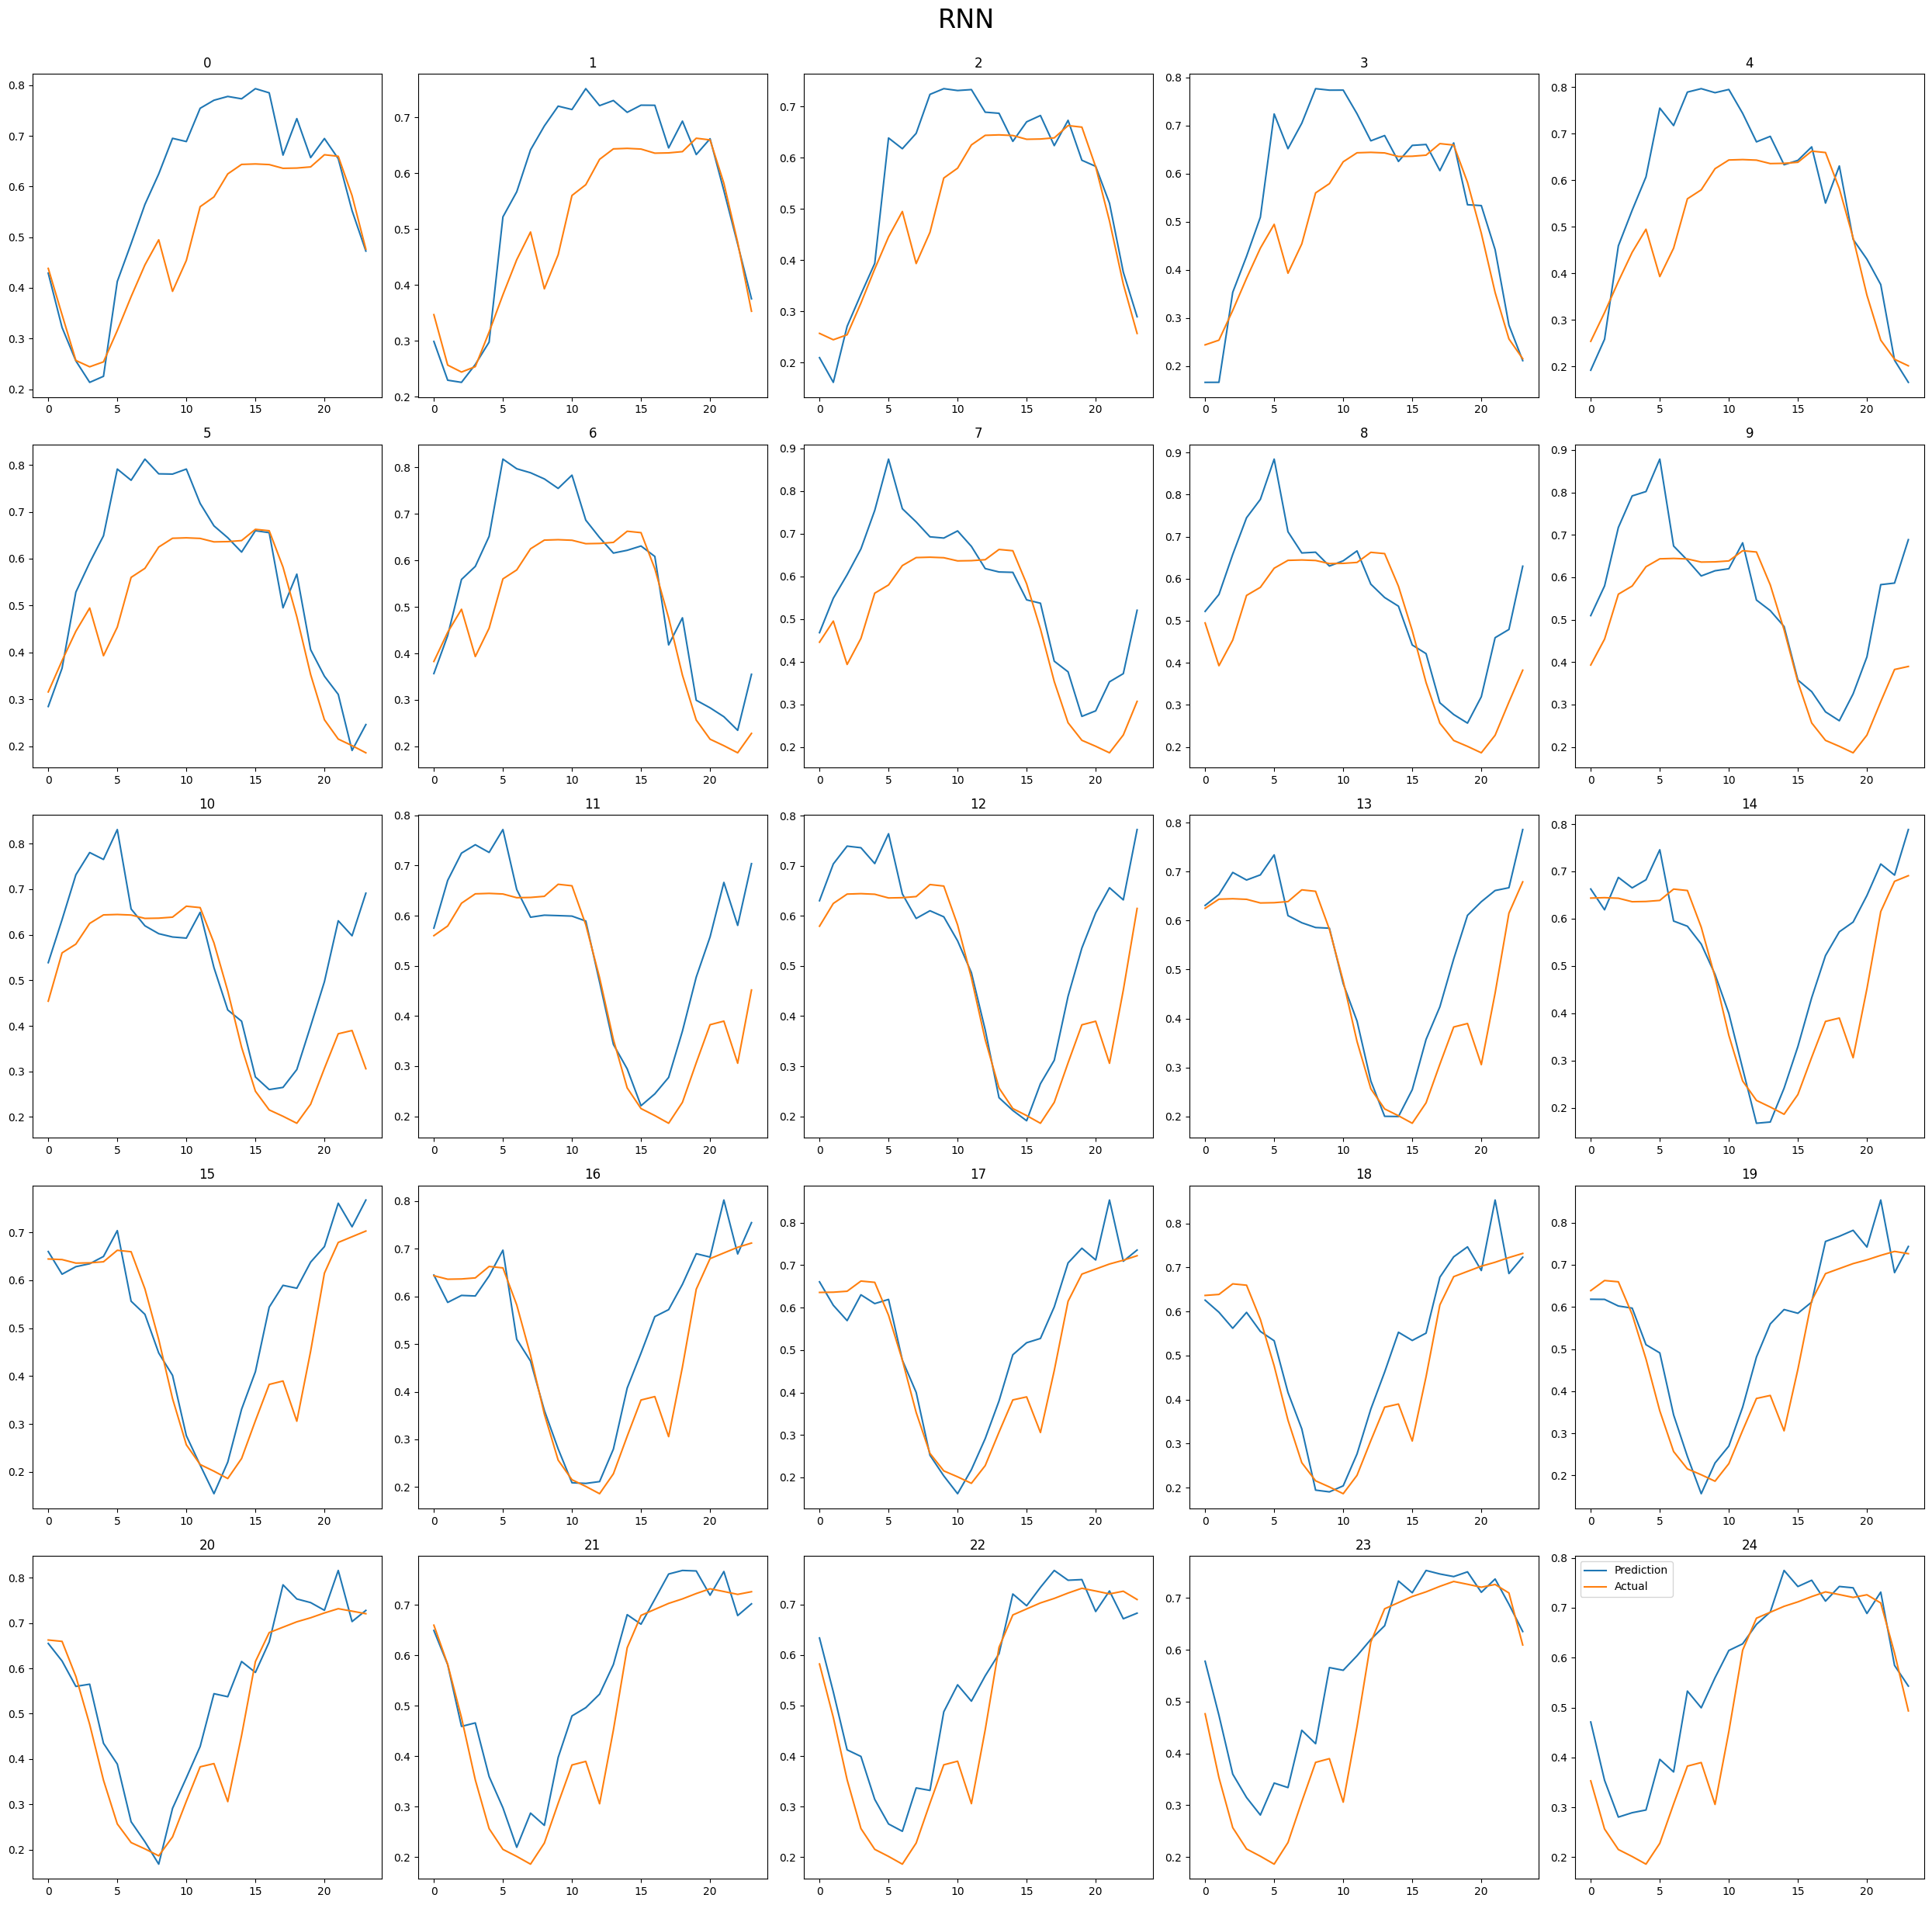

In [141]:
fig, axs = plt.subplots(5, 5, figsize=(25, 25))
axs = axs.flatten()

for i, column in enumerate(predictions_1):
    ax = axs[i]
    # TODO seems to work but check why column[0]
    ax.plot(column[0], label="Prediction")
    ax.plot(Y_val[i, :, 0], label="Actual")
    ax.title.set_text(i)

fig.suptitle("RNN", fontsize=24)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.legend()
plt.show()

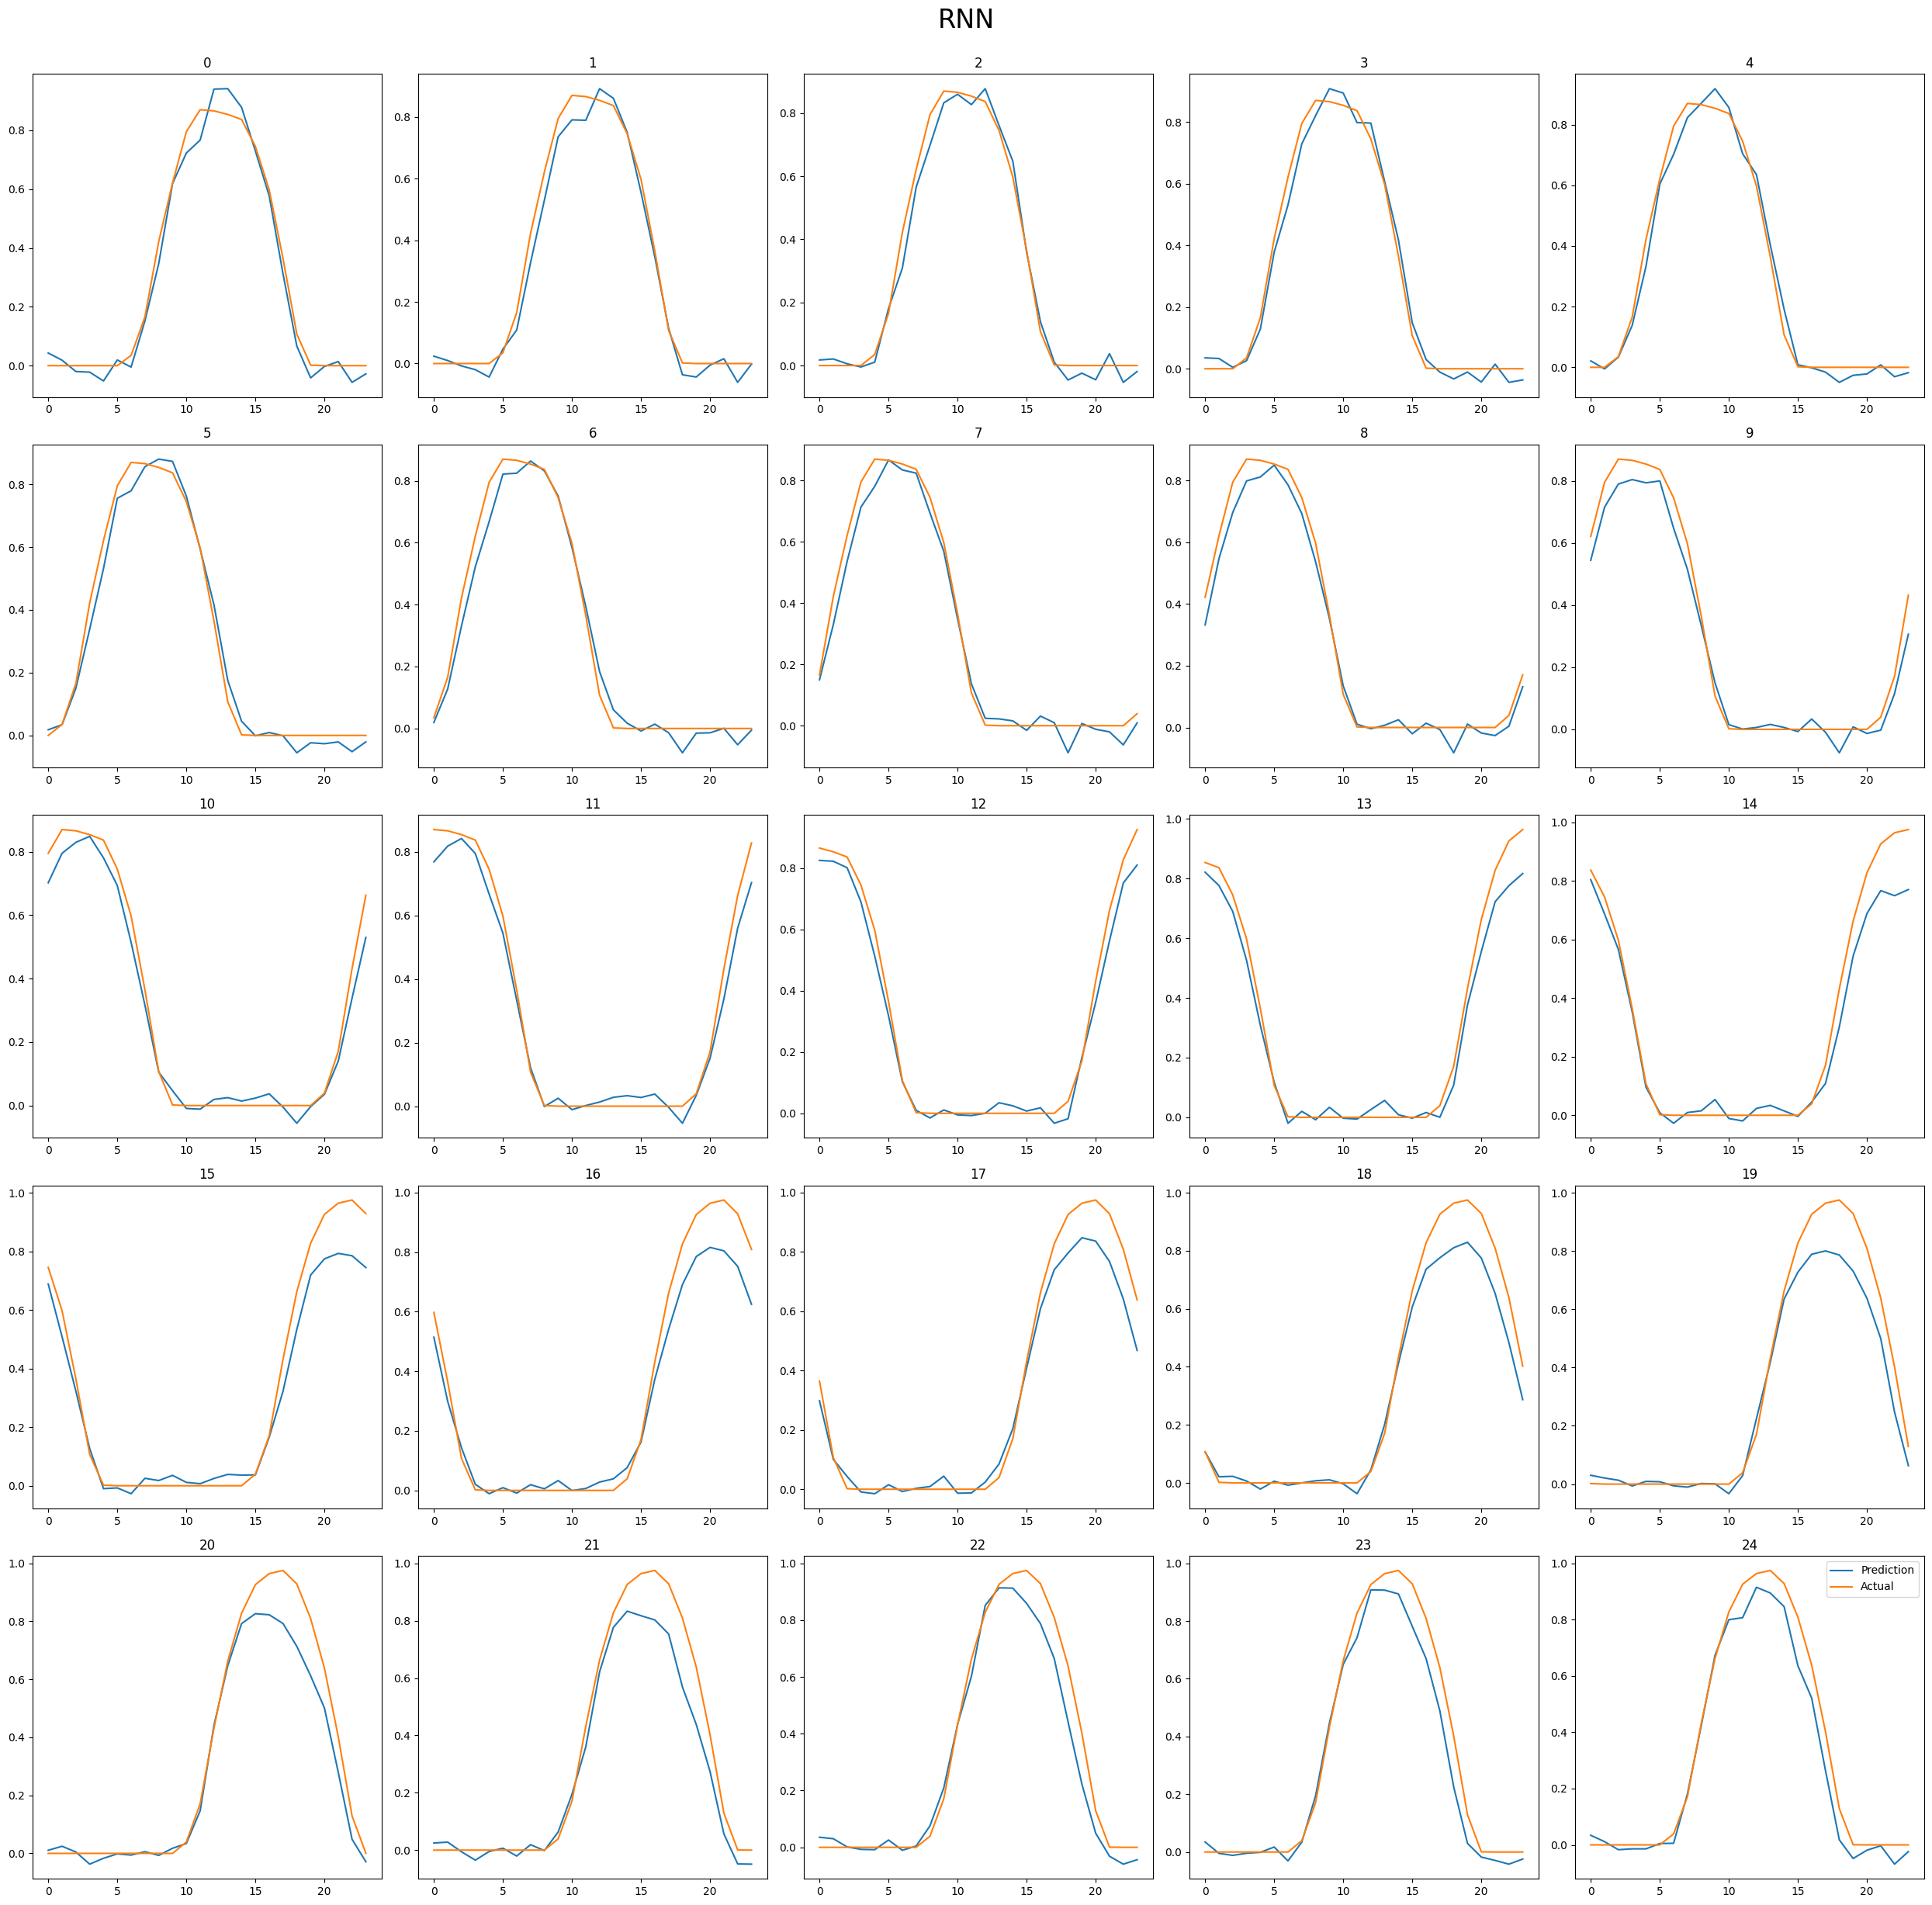

In [142]:
fig, axs = plt.subplots(5, 5, figsize=(25, 25))
axs = axs.flatten()

for i, column in enumerate(predictions_2):
    ax = axs[i]
    # TODO seems to work but check why column[0]
    ax.plot(column[0], label="Prediction")
    ax.plot(Y_val[i, :, 1], label="Actual")
    ax.title.set_text(i)

fig.suptitle("RNN", fontsize=24)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.legend()
plt.show()

In [143]:
rmse = 0
for i in range(len(predictions_1)):
    print(f'pred={i}, num = {sqrt(mean_squared_error(predictions_1[i][0], Y_val[i, :, 0]))}')
    rmse += sqrt(mean_squared_error(predictions_1[i][0], Y_val[i, :, 0]))

rmse /= len(predictions_1)    
print(f"RMSE = {rmse}")

pred=0, num = 0.12396083790262259
pred=1, num = 0.11313121804966295
pred=2, num = 0.1078429891682652
pred=3, num = 0.11865854909464149
pred=4, num = 0.13447508597935745
pred=5, num = 0.12998532396828882
pred=6, num = 0.11631185525289156
pred=7, num = 0.12625444218650655
pred=8, num = 0.13201797340206448
pred=9, num = 0.1413596749747436
pred=10, num = 0.13930614980266878
pred=11, num = 0.12406541134589327
pred=12, num = 0.11872553714889378
pred=13, num = 0.11220376541906692
pred=14, num = 0.10373067372167677
pred=15, num = 0.09925549293494394
pred=16, num = 0.08778564746197098
pred=17, num = 0.08170763279798968
pred=18, num = 0.0824988019871421
pred=19, num = 0.09602733864645734
pred=20, num = 0.08442062646258784
pred=21, num = 0.07986257199170438
pred=22, num = 0.08118500639641547
pred=23, num = 0.09771229088136255
pred=24, num = 0.09541497916368705
RMSE = 0.10911599504566023


In [144]:
rmse = 0
for i in range(len(predictions_2)):
    print(f'pred={i}, num = {sqrt(mean_squared_error(predictions_2[i][0], Y_val[i, :, 1]))}')
    rmse += sqrt(mean_squared_error(predictions_2[i][0], Y_val[i, :, 1]))

rmse /= len(predictions_2)    
print(f"RMSE = {rmse}")

pred=0, num = 0.048036551878708034
pred=1, num = 0.046129708769453714
pred=2, num = 0.042772795837712485
pred=3, num = 0.04093304536118422
pred=4, num = 0.041806189388999666
pred=5, num = 0.043153876644169135
pred=6, num = 0.050223474790967435
pred=7, num = 0.046279139299289035
pred=8, num = 0.04689691823658049
pred=9, num = 0.05586403285521867
pred=10, num = 0.05260734936238956
pred=11, num = 0.0532788739864587
pred=12, num = 0.04878826454157559
pred=13, num = 0.0638294804291236
pred=14, num = 0.08661528750005278
pred=15, num = 0.08732016762958279
pred=16, num = 0.08928080356902542
pred=17, num = 0.0807729388519782
pred=18, num = 0.0837660507219559
pred=19, num = 0.09446688820439449
pred=20, num = 0.09015432976388466
pred=21, num = 0.09772758617936464
pred=22, num = 0.0792722439778036
pred=23, num = 0.07337465986556038
pred=24, num = 0.06975542775737396
RMSE = 0.06452424341611229
